## Importing Libraries

In [54]:
import itertools
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
warnings.filterwarnings("ignore")

## Importing Data

In [55]:
stocks = pd.read_csv('SBI_Historical_Data.csv')

## Data Preprocessing

In [56]:
stocks.head()
# stocks.info()
# stocks.describe()

,Date,Price,Open,High,Low,Vol.,Change %
0,"Aug 07, 2020",190.65,191.45,192.10,189.55,44.82M,-0.16%
1,"Aug 06, 2020",190.95,192.30,194.50,190.25,59.74M,-0.26%
2,"Aug 05, 2020",191.45,192.75,196.85,191.00,68.89M,-0.08%
3,"Aug 04, 2020",191.60,193.35,193.80,190.50,43.87M,-0.34%
4,"Aug 03, 2020",192.25,192.00,194.60,190.05,72.46M,0.42%


In [57]:
stocks.isna().sum().any()

False

In [58]:
stocks["Date"] = pd.to_datetime(stocks["Date"])
stocks["Date"].min(), stocks["Date"].max()

(Timestamp('2015-01-01 00:00:00'), Timestamp('2020-08-07 00:00:00'))

In [59]:
stock_data = stocks[['Date', 'Price']].sort_values('Date')
stock_data = stock_data.groupby('Date')['Price'].sum().reset_index()
stock_data.set_index('Date', inplace=True)
stock_data

,Price
Date,
2015-01-01,314.00
2015-01-02,315.25
2015-01-05,312.75
2015-01-06,299.90
2015-01-07,300.15
...,...
2020-08-03,192.25
2020-08-04,191.60
2020-08-05,191.45


## Data Visualisation

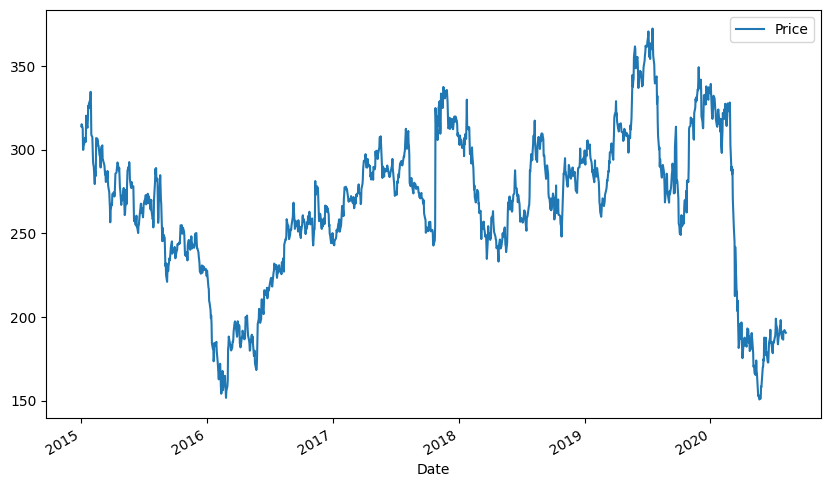

In [60]:
stock_data.plot(figsize=(10,6))
plt.show()

## Resampling

In [61]:
data = stock_data['Price'].resample('MS').mean()

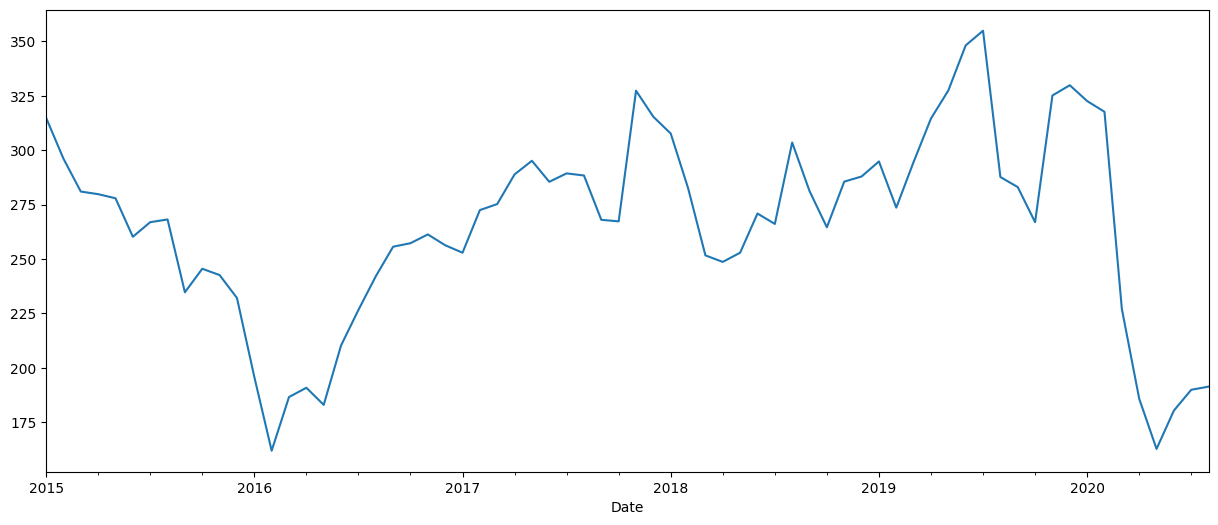

In [62]:
data.plot(figsize=(15, 6))
plt.show()

## ADF Test
Null Hypothesis: The series is not stationary. <br>
Alternate Hypothesis: The series is stationary.

In [63]:
result = adfuller(data)
print ('Results of ADF Test:')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

Results of ADF Test:
ADF Statistic: -2.460279
p-value: 0.125440
Critical Values:
	1%: -3.5335601309235605
	5%: -2.9064436883991434
	10%: -2.590723948576676


since ADF statistic > critical value at 1%. we fail to reject the null hypothesis
##### i.e. series is not stationary.

## KPSS Test
Null Hypothesis: The process is trend stationary. <br>
Alternate Hypothesis: The series  is not stationary.

In [64]:
kpsstest = kpss(data)
print ('Results of KPSS Test:')
print('KPSS Statistic: %f' % kpsstest[0])
print('p-value: %f' % kpsstest[1])
print('Critical Values:')
for key, value in kpsstest[3].items():
    print(f'\t{key}: {value}')

Results of KPSS Test:
KPSS Statistic: 0.201291
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


since KPSS statistic < critical values. we reject the null hypothesis and accept the alternative hypothesis
##### i.e. series is not stationary.

#### From above two tests we can conclude the series is not stationary. Removing seasonality:

<Axes: xlabel='Date'>

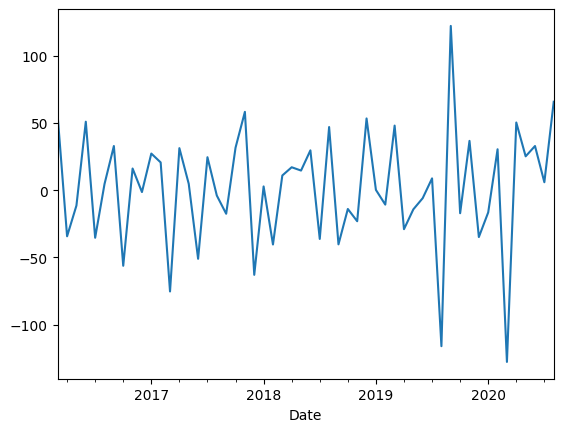

In [74]:
data = data - data.shift(1)
data.dropna(inplace=True)
data.plot()

## Decomposing

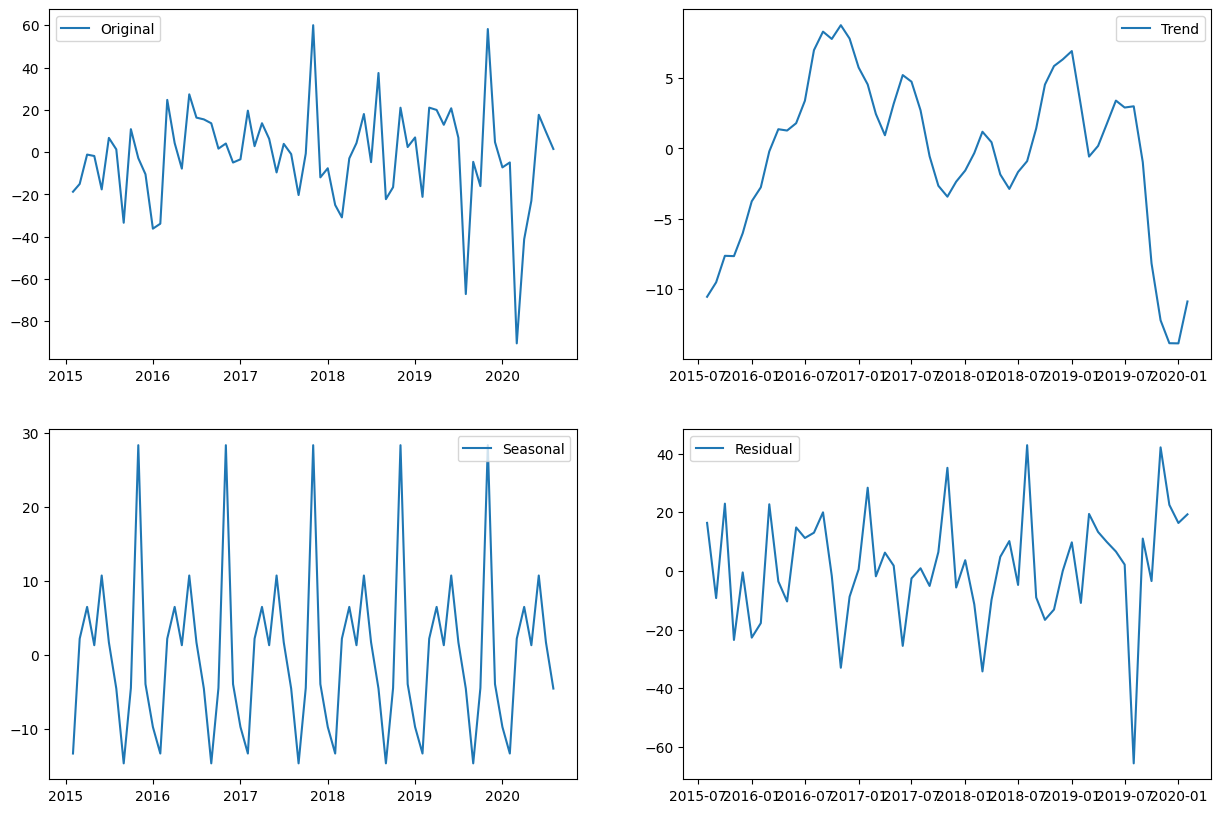

In [66]:
decomposition = seasonal_decompose(data)
fig, ax = plt.subplots(2,2, figsize=(15,10))
ax[0,0].plot(data, label = 'Original')
ax[0,0].legend(loc = 'best')

trend = decomposition.trend
ax[0,1].plot(trend, label = 'Trend')
ax[0,1].legend(loc = 'best')

seasonal = decomposition.seasonal
ax[1,0].plot(seasonal, label = 'Seasonal')
ax[1,0].legend(loc = 'best')

residual = decomposition.resid
ax[1,1].plot(residual, label = 'Residual')
ax[1,1].legend(loc='best')
plt.show()

## Time Series Forecasting

In [67]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

## Finding Best Parameters

In [68]:
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit(disp=False)
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            continue

print(f"Best SARIMAX{best_pdq}x{best_seasonal_pdq} model - AIC:{best_aic}")

Best SARIMAX(0, 1, 1)x(1, 1, 1, 12) model - AIC:383.8587495310494


## Fitting the model

In [69]:
mod = sm.tsa.statespace.SARIMAX(data,
                                order=best_pdq,
                                seasonal_order=best_seasonal_pdq,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit(disp=False)
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0749      0.161     -6.674      0.000      -1.391      -0.759
ar.S.L12      -0.7249      0.167     -4.343      0.000      -1.052      -0.398
ma.S.L12      -0.2529      0.346     -0.732      0.464      -0.930       0.424
sigma2       581.6433    197.175      2.950      0.003     195.187     968.100


## Forecast Validation

comparing predicted sales to real sales of the time series to understand the accuracy of our forecasts

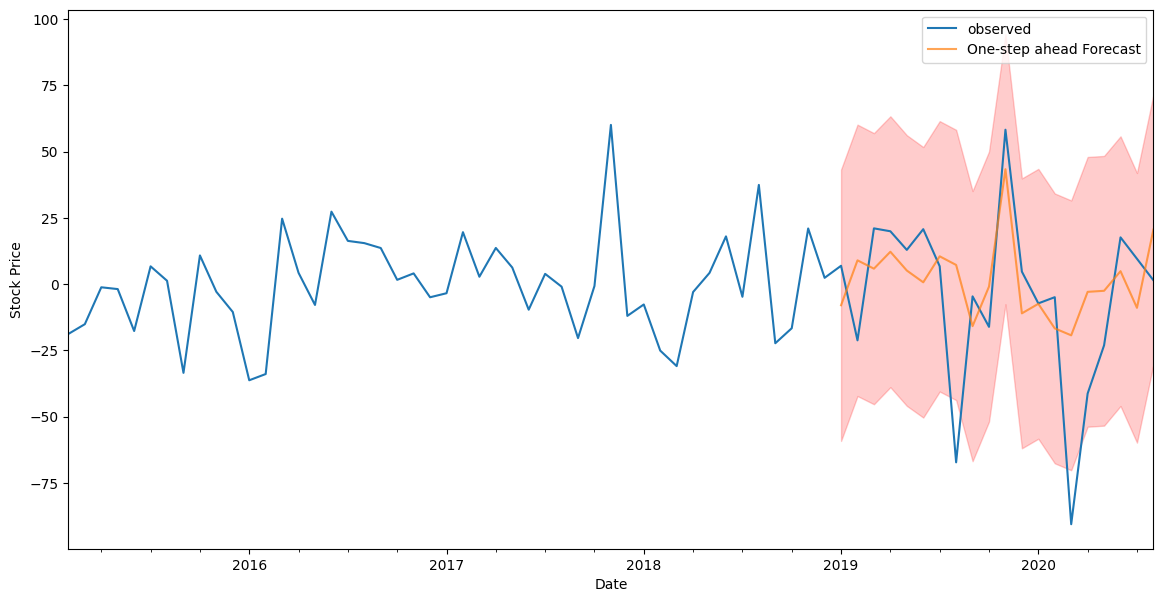

In [70]:
pred = results.get_prediction(start=pd.to_datetime('2019-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = data['2015':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='red', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Stock Price')
plt.legend()
plt.show()

## Calculating MSE and RMSE

In [71]:
data_forecasted = pred.predicted_mean
data_truth = data['2019-01-01':]
mse = ((data_forecasted - data_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 812.03
The Root Mean Squared Error of our forecasts is 28.5


## Forecast Visualisation

            lower Price  upper Price
2020-09-01   -77.956797    23.717690
2020-10-01   -70.669499    31.251477
2020-11-01   -30.391648    71.775223
2020-12-01   -59.218696    43.193479
2021-01-01   -55.691790    46.965112
2021-02-01   -78.506336    24.398571
2021-03-01   -50.792029    52.356423
2021-04-01   -45.170447    58.220976
2021-05-01   -49.184792    54.449033
2021-06-01   -40.493566    63.382095
2021-07-01   -54.652739    49.464196
2021-08-01  -101.431365     2.926287
2021-09-01   -68.617360    36.159995


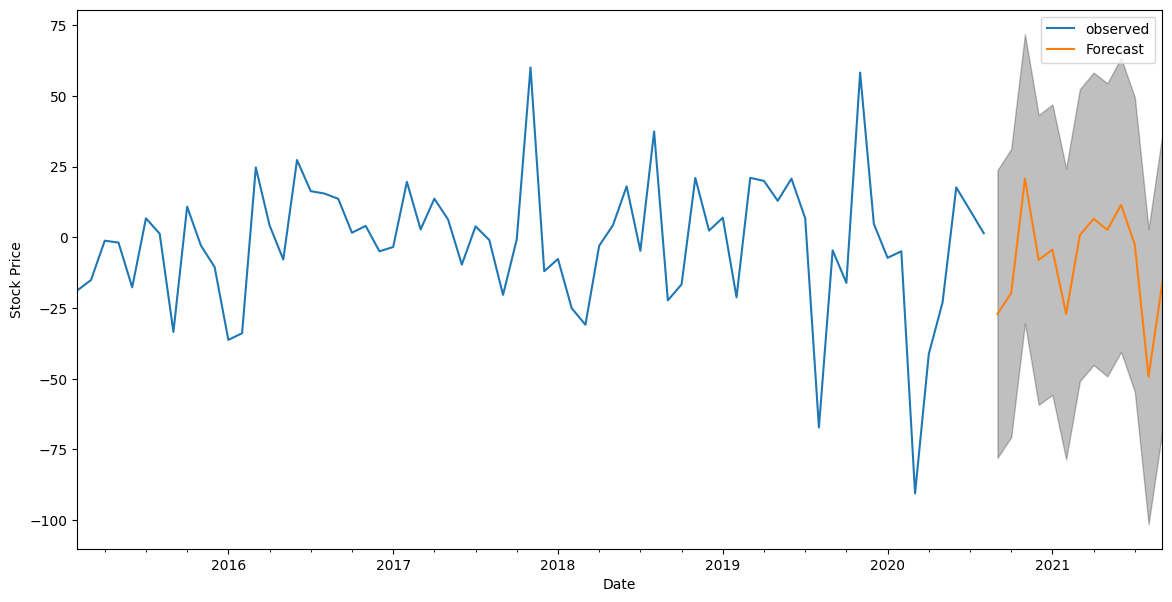

In [72]:
pred_uc = results.get_forecast(steps=13)
pred_ci = pred_uc.conf_int()
ax = data.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Stock Price')
print(pred_ci)
plt.legend()
plt.show()